# Evaluate Proxima effect on trajectories
Here we look at the experiments where we only train a model once in NPT and look for the oscillations and the effect of blending. 

In [1]:
import os
from glob import glob
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches

from cascade.learning.torchani import TorchANI
from pathlib import Path
from ase.io import read
from ase import units
import pickle as pkl
import pandas as pd
import numpy as np
import json

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Read in data


In [3]:
run_dirs = sorted(glob('runs/800K-npt-single-train/*'))
run_dirs

['runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-00e6f7df',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-05bd7fef',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-0aff6fba',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-105292bb',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-1418cfda',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-160f5dc6',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-1ffe8b75',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-24aacf2b',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-2fc33503',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-399f3417',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-3c135b25',
 'runs/800K-npt-single-train/si-vacancy-2x2

In [4]:
len(run_dirs)

114

In [7]:
param_vars = ['seed', 'temperature', 'n_blending_steps', 'min_target_frac', 'target_error', 'stress_tau', 'steps']

## Look at the run parameters

In [8]:
params = []
for d in run_dirs:
    try:
        params.append(json.loads((Path(d)/'params.json').read_text()))
    except: 
        print(f'couldnt find {d}/params.json; skipping')
        continue
    params[-1]['dir'] = d
params = pd.DataFrame(params)

## read in the runs and append the hash

In [9]:
data = []
hashes = []
for i, row in params.iterrows(): 
    # read in the results for each set of parameters
    run = row['dir']
    try:
        _data = pd.read_json(Path(run)/'proxima-log.json', lines=True)
    except: 
        print('couldnt read proximal log for', run)
        hashes.append(None)
        continue
    # make sure to have timestep
    _data.reset_index(names='timestep', inplace=True)

    # keep the hash of the run
    _hash = run.split('-')[-1]
    hashes.append(_hash)
    _data['hash'] = _hash 
    #traj = read(Path(run)/'md.traj', index=':')
    #break    
    # add the parameters to the experiment df for easy plotting, grouping, etc
    for var in param_vars:
        _data[var] = row[var]
    data.append(_data)

# track the hashes as well for param lookup
params['hash'] = hashes
data = pd.concat(data)

In [10]:
_params = params[param_vars+['hash']].sort_values(param_vars)
_params.describe()

,seed,temperature,n_blending_steps,min_target_frac,target_error,stress_tau,steps
count,114.000000,114.0,114.000000,114.000000,1.140000e+02,114.0,114.0
mean,2.500000,800.0,9.473684,0.305263,6.394737e-01,25.0,2048.0
std,1.715365,0.0,8.291386,0.233800,2.670284e-01,0.0,0.0
min,0.000000,800.0,0.000000,0.100000,1.000000e-12,25.0,2048.0
25%,1.000000,800.0,0.000000,0.100000,4.500000e-01,25.0,2048.0
50%,2.500000,800.0,10.000000,0.200000,4.500000e-01,25.0,2048.0
75%,4.000000,800.0,20.000000,0.500000,9.000000e-01,25.0,2048.0
max,5.000000,800.0,20.000000,1.000000,9.000000e-01,25.0,2048.0


In [11]:
_params.duplicated().sum()

0

In [14]:
data['hash'].value_counts().unique()

array([2048])

In [15]:
runs

NameError: name 'runs' is not defined

In [28]:
runs['hash'][(runs['min_target_frac'] != 1) & runs['n_blending_steps'] == 0]

1    46eaa9f3
5    daefb0ba
8    72b94ed1
Name: hash, dtype: object

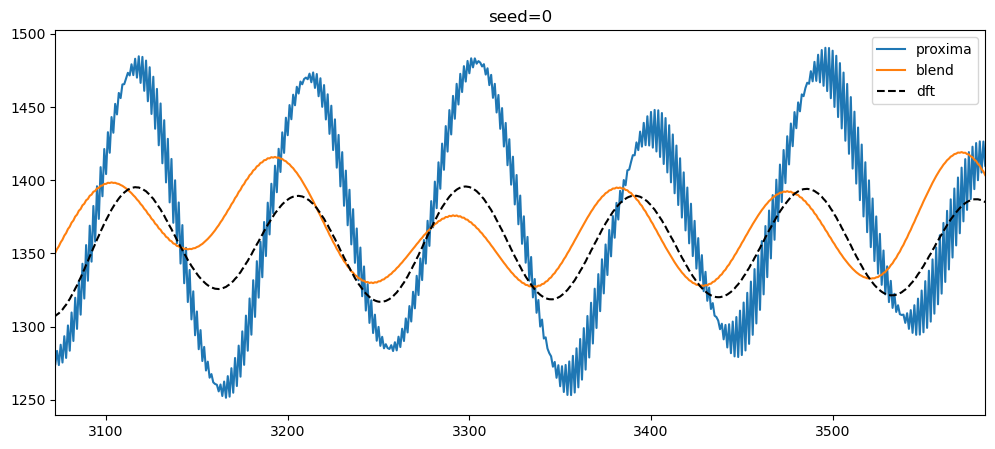

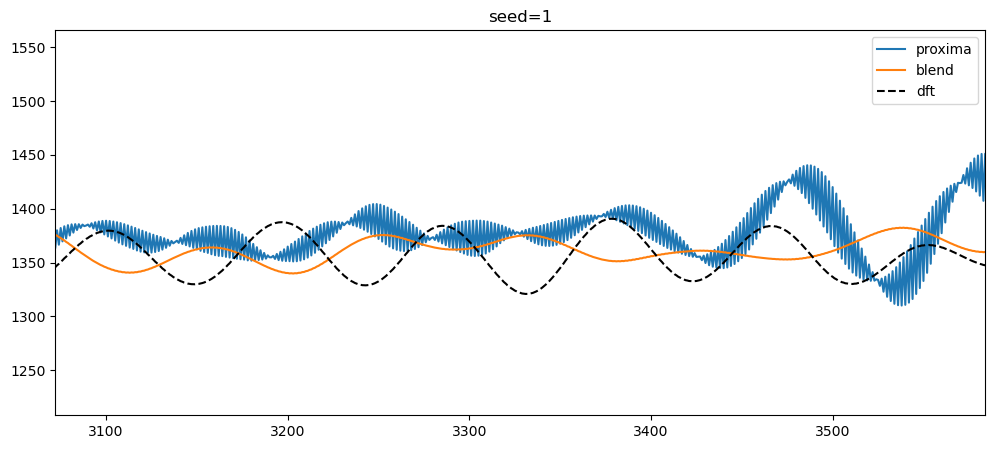

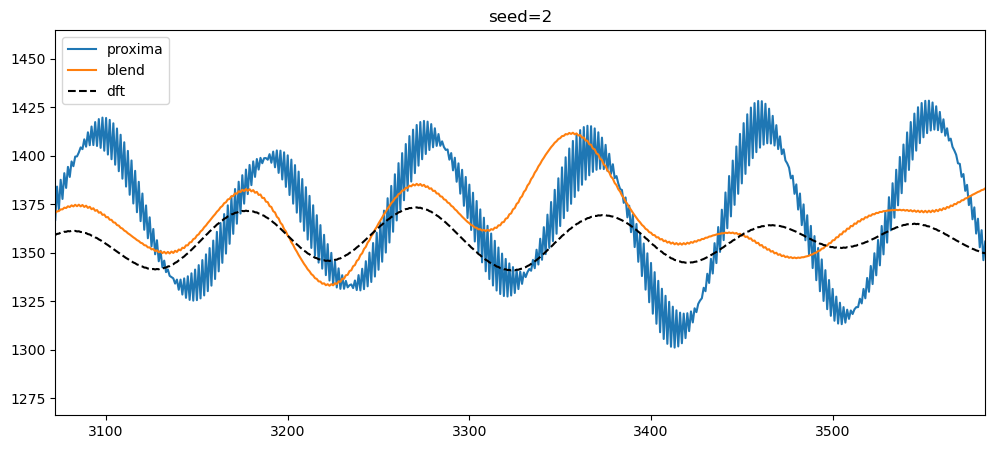

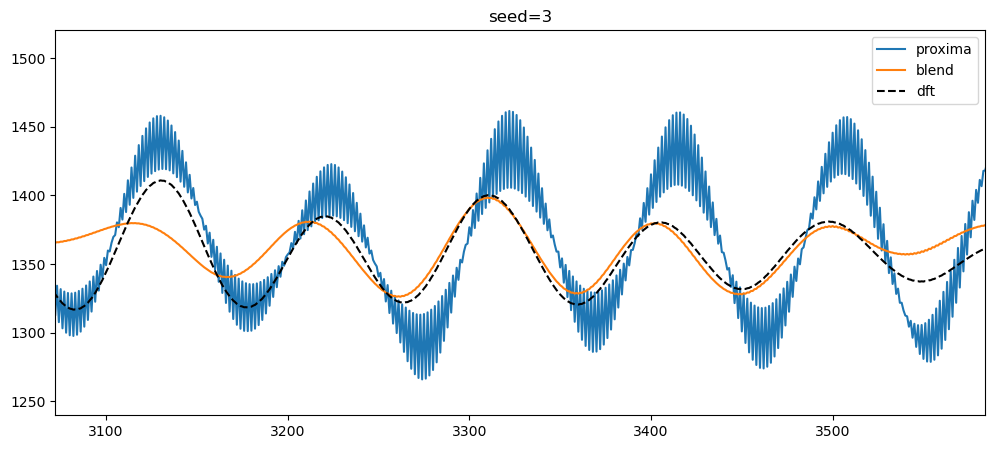

In [39]:
for seed in range(4):

    fig, ax = plt.subplots(figsize=(12,5))
    runs = _params.query(f'seed == {seed}')
    dft_hash = runs['hash'][runs['min_target_frac'] == 1].item()
    blend_hash = runs['hash'][runs['n_blending_steps'] == 10].item()
    proxima_hash = runs['hash'][(runs['min_target_frac'] != 1) & (runs['n_blending_steps'] == 0)].item()

    blend_traj = data.query(f'hash == "{blend_hash}"')
    proxima_traj = data.query(f'hash == "{proxima_hash}"')
    dft_traj = data.query(f'hash == "{dft_hash}"')
    
    plt.plot(proxima_traj['volume'], label='proxima')
    plt.plot(blend_traj['volume'], label='blend')
    plt.plot(dft_traj['volume'], label='dft', color='k', linestyle='dashed')
    plt.title(f"seed={seed}")
    plt.xlim(2048*1.5, 2048*1.75)#, 4096)
    plt.legend()
    plt.show()
    

In [66]:
blend_hash, proxima_hash

('ecddd413', 'cae8e042')

In [17]:
data.columns

Index(['timestep', 'step_time', 'energy', 'maximum_force', 'stress', 'temperature', 'volume', 'used_surrogate', 'proxima_alpha', 'proxima_threshold', 'proxima_blending_step', 'proxima_lambda_target', 'last_uncer', 'last_error', 'total_invocations', 'target_invocations', 'model_version', 'hash', 'seed', 'n_blending_steps', 'min_target_frac', 'target_error', 'stress_tau', 'steps'], dtype='object')

In [18]:
data.head()

,timestep,step_time,energy,maximum_force,stress,temperature,volume,used_surrogate,proxima_alpha,proxima_threshold,proxima_blending_step,proxima_lambda_target,last_uncer,last_error,total_invocations,target_invocations,model_version,hash,seed,n_blending_steps,min_target_frac,target_error,stress_tau,steps
0,0,8.758060,-6684.002357,0.640134,"[-0.034064950674633006, -0.033984689113805006,...",800.0,1280.824056,False,NaN,NaN,0,NaN,0.009403,0.640530,2,2,0,01805009,3,0,0.1,4.5,25.0,4096
1,1,5.152223,-6683.932374,0.912785,"[-0.033752275089244, -0.033582710657265, -0.03...",800.0,1281.572936,False,NaN,NaN,0,NaN,0.009850,0.913031,3,3,0,01805009,3,0,0.1,4.5,25.0,4096
2,2,5.363058,-6683.804736,1.176208,"[-0.033485458901801005, -0.033220645502494005,...",800.0,1282.324309,False,NaN,NaN,0,NaN,0.010252,1.176584,4,4,0,01805009,3,0,0.1,4.5,25.0,4096
3,3,5.209425,-6683.649263,1.423889,"[-0.03286263072042, -0.032495885968113, -0.033...",800.0,1283.811212,False,NaN,NaN,0,NaN,0.010610,1.424672,5,5,0,01805009,3,0,0.1,4.5,25.0,4096
4,4,6.549386,-6683.448237,1.654450,"[-0.032272771383617005, -0.031801034537219997,...",800.0,1285.304909,False,NaN,NaN,0,NaN,0.010902,1.655874,6,6,0,01805009,3,0,0.1,4.5,25.0,4096


In [19]:
data.describe()

,timestep,step_time,energy,maximum_force,temperature,volume,proxima_alpha,proxima_threshold,proxima_blending_step,proxima_lambda_target,last_uncer,last_error,total_invocations,target_invocations,model_version,seed,n_blending_steps,min_target_frac,target_error,stress_tau,steps
count,11401.000000,11401.000000,11401.000000,11401.000000,11401.0,1.140100e+04,1.132900e+04,11329.000000,11401.000000,2052.000000,11401.000000,11401.000000,11401.000000,11401.000000,11401.0,11401.000000,11401.000000,1.140100e+04,11401.0,11401.0,11401.0
mean,806.262258,9.213554,-2200.911061,3.258944,800.0,1.641149e+61,6.394790e+04,0.207257,1.447154,0.190505,0.043212,11.214237,1295.006578,378.981230,0.0,1.662661,1.799842,1.000000e-01,4.5,25.0,4096.0
std,852.740925,23.472287,4872.564173,11.090490,0.0,1.749865e+63,1.706327e+06,0.237708,3.470836,0.378642,0.021601,22.126832,1206.073512,545.777944,0.0,1.040858,3.841912,5.135007e-15,0.0,0.0,0.0
min,0.000000,0.026517,-7121.328324,0.000000,800.0,2.955760e+02,3.451950e+01,0.000000,0.000000,0.000000,0.000000,0.572873,2.000000,2.000000,0.0,0.000000,0.000000,1.000000e-01,4.5,25.0,4096.0
25%,237.000000,0.122674,-6589.670443,0.033181,800.0,1.504025e+03,8.753427e+01,0.017953,0.000000,0.000000,0.031040,2.949461,425.000000,84.000000,0.0,1.000000,0.000000,1.000000e-01,4.5,25.0,4096.0
50%,494.000000,0.360845,-4.351285,0.050948,800.0,1.764631e+03,1.286227e+02,0.129596,0.000000,0.000000,0.041564,4.725021,877.000000,171.000000,0.0,2.000000,0.000000,1.000000e-01,4.5,25.0,4096.0
75%,982.000000,9.769727,0.315702,3.386726,800.0,2.381811e+03,2.210645e+02,0.292187,0.000000,0.024472,0.053374,10.167197,1720.000000,332.000000,0.0,2.000000,0.000000,1.000000e-01,4.5,25.0,4096.0
max,3454.000000,597.178272,396062.784506,396.906314,800.0,1.868425e+65,7.542477e+07,1.206087,10.000000,1.000000,0.263807,396.874250,4691.000000,2329.000000,0.0,3.000000,10.000000,1.000000e-01,4.5,25.0,4096.0


In [20]:
data.hash.nunique()

12

## Plot DFT only trajectories

In [21]:
dft_only = data.query('min_target_frac == 1')

First I verify that the DFT only trajectories are what I think they are: 

In [22]:
only_target = (dft_only['total_invocations']==dft_only['target_invocations']).all()
assert only_target, 'target was not always invoked'
only_target

True

In [23]:
dft_only.hash.nunique()

0

In [24]:
no_blend = (dft_only['proxima_blending_step'] == 0).all()
assert no_blend, 'proxima should not blend'
no_blend

True

In [25]:
for i, (g, row) in enumerate(dft_only.sort_values(['hash'] + param_vars).groupby(param_vars)): 
    fig, ax = plt.subplots(figsize=(15,2.5))
    plt.plot(row['timestep'], row['volume'], '-o', ms=1)
    plt.ylabel('V ($\AA ^3$)')
    plt.xlabel('time (fs)')

    _params = params.query(f'hash == "{row["hash"].iloc[0]}"')
    _params = ', '.join([f'{var}={_params[var].iloc[0]}' for var in param_vars])
    plt.title(f"DFT-only " + _params)
    plt.tight_layout()
    plt.show()

In [27]:
dft_only

,timestep,step_time,energy,maximum_force,stress,temperature,volume,used_surrogate,proxima_alpha,proxima_threshold,proxima_blending_step,proxima_lambda_target,last_uncer,last_error,total_invocations,target_invocations,model_version,hash,seed,n_blending_steps,min_target_frac,target_error,stress_tau,steps


## Plot proxima + blending trajectories

this plots all of them, which is good for a quick inspection

In [19]:
experimental = data.query('min_target_frac < 1')

## Make a detailed plot of a single trajectory
This is a good paper/slide figure

In [41]:
ref_traj = dft_only.query('temperature == 800 and steps == 2048 and seed == 0')
blend_traj = data.query('hash == "ecddd413"')

In [42]:
rc = {'axes.titlesize':12, 
      'axes.labelsize':14, 
      'xtick.labelsize': 12, 
      'ytick.labelsize': 12, 
      'legend.fontsize': 12}

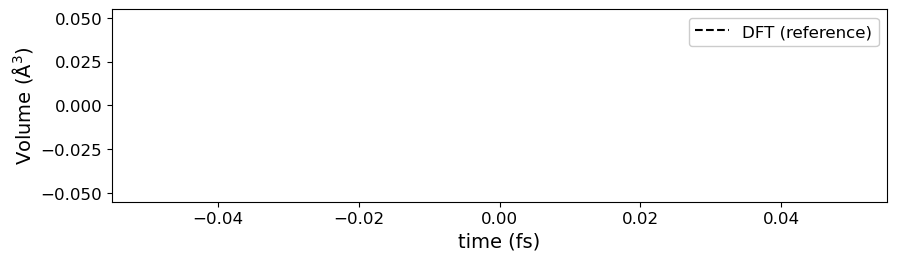

In [37]:
with mpl.rc_context(rc=rc):
    xlim = (1000, 1600)
    fig, ax = plt.subplots(1, figsize=(10,2.5))
    ax.plot(ref_traj['volume'], color='k', linestyle='dashed', label='DFT (reference)')
    ax.legend(#title='Forces', 
              #loc='upper center', 
              #bbox_to_anchor=(0.5, 1.25),
              framealpha=1
             )
    ax.set_ylabel('Volume ($\mathrm{\AA}^3$)')
    ax.set_xlabel('time (fs)')
    plt.savefig('dft-only.png', dpi=500, bbox_inches='tight')
    plt.show()

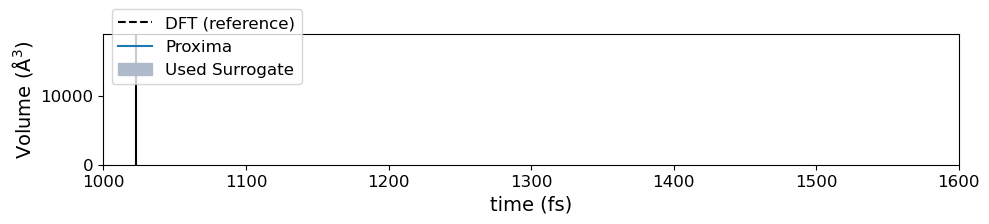

In [48]:
with mpl.rc_context(rc=rc):
    #xlim = (1000, 1600)
    fig, axs = plt.subplots(1, figsize=(10,2.5))
    ax = axs
    
    l2 = ax.plot(ref_traj['volume'], color='k', linestyle='dashed', label='DFT (reference)')
    l1 = ax.plot(traj['volume'], color='tab:blue', label='Proxima')
    ax.set_ylabel('Volume ($\mathrm{\AA}^3$)')
    ax.set_xlabel('time (fs)')
    c = ax.pcolorfast(ax.get_xlim(), 
                  ax.get_ylim(), 
                  traj['used_surrogate'].values[np.newaxis], 
                  alpha=0.3, 
                  cmap='Blues', 
                  label='Used ML')
    ax.set_xlim(*xlim)
    
    blue_patch = mpatches.Patch(color='#afbbcb', label='Used surrogate')
    leg, lab = ax.get_legend_handles_labels()
    leg.append(blue_patch)
    lab.append('Used Surrogate')
    plt.legend(leg, 
               lab, 
               loc='upper left',
               framealpha=0.8, 
               bbox_to_anchor=(0.0, 1.25),
              )
    plt.axvline(1023, color='k')
    plt.tight_layout()
    plt.savefig('dft-proxima.png', dpi=500)
    plt.show()

In [39]:
with mpl.rc_context(rc=rc):
    xlim = (1000, 1600)
    fig, axs = plt.subplots(2, figsize=(10,5))
    ax = axs[0]
    
    #l2 = ax.plot(ref_traj['volume'], color='k', linestyle='dashed', label='DFT (reference)')
    l1 = ax.plot(traj['volume'], color='tab:blue', label='Proxima')
    l2 = ax.plot(blend_traj['volume'], color='tab:red', label='Proxima+Blend')
    ax.set_ylabel('Volume ($\mathrm{\AA}^3$)')
    ax.set_xlabel('time (fs)')
    ax.pcolorfast(ax.get_xlim(), 
                  ax.get_ylim(), 
                  traj['used_surrogate'].values[np.newaxis], 
                  alpha=0.3, 
                  cmap='Blues', label='Used ML') 
    
    # can give it fill between just to get the legend
    
    ax.axvline(1023, color='k')
    ax.set_xlim(*xlim)
    #ax.fill_between(traj['volume'], traj['used_surrogate'], 1, where=(traj['used_surrogate' ]>0), color='red', alpha=0.2)
    blue_patch = mpatches.Patch(color='#afbbcb', label='Used surrogate (Proxima only)')
    leg, lab = ax.get_legend_handles_labels()
    leg.append(blue_patch)
    lab.append('Proxima used surrogate')
    ax.legend(leg, 
               lab, 
               loc='upper left',
               framealpha=0.8, 
               bbox_to_anchor=(0.0, 1.35),
              )
    ax = axs[1]
    lambda_ml = 1-blend_traj['proxima_lambda_target']
    ax.plot(lambda_ml, color='tab:red')
    ax.axvline(1023, color='k')
    ax.set_xlim(*xlim)
    ax.set_ylabel('$\lambda_\mathrm{ML}$')
    ax.set_xlabel('time (fs)')
    plt.tight_layout()
    plt.savefig('dft-proxima-blend.png', dpi=500)
    plt.show()

NameError: name 'traj' is not defined

In [40]:
traj['step_time'].argmax()

1023

In [41]:
blend_traj['step_time'].argmax()

1023

In [42]:
traj.iloc[1024:]['used_surrogate'].mean()

0.4453125

In [43]:
blend_traj[1024:]['used_surrogate'].mean()

0.830078125

In [44]:
blend_traj['full_surrogate'] = blend_traj['used_surrogate'] & (blend_traj['proxima_lambda_target'] == 0)

/tmp/ipykernel_485763/2618731154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blend_traj['full_surrogate'] = blend_traj['used_surrogate'] & (blend_traj['proxima_lambda_target'] == 0)


In [45]:
blend_traj.iloc[1024:]['full_surrogate'].mean()

0.7841796875

## Summary quantities
Here we'll average some quantities over our experimental conditions to get a sense of whats happening in aggregate

### Combining the dft data in for seaborn
This is a little sneaky, but it will get the DFT data on the seaborn plots without me having to plot things manualy

In [46]:
dft_only['target_error'] = 0.45

/tmp/ipykernel_485763/3036850189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_only['target_error'] = 0.45


In [47]:
_dft_only = dft_only.copy()
_dft_only['target_error'] = 0.9
dft_only = pd.concat([dft_only, _dft_only])

In [48]:
experimental = pd.concat([experimental, dft_only])

NameError: name 'experimental' is not defined

## Volume

Takeaways: 
* the volume matches DFT for the smaller target error (0.45)
* For the larger target error, blending only really matters for larger target fractions
   - 0.5 target fraction matches dft well, probably because mostly using DFT
 
* Notably even the largest errors are quite small percentage wise

In [49]:
v_mean = experimental.query('timestep > 1024').groupby(param_vars)['volume'].mean().reset_index()

NameError: name 'experimental' is not defined

In [50]:
v_mean.head()
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            row='target_error',
            y='volume',
            data=v_mean.query('volume < 1e5'),
            sharey=True)
plt.show()

NameError: name 'v_mean' is not defined

## Target fraction

Contextualizing the above results, the takeaways: 
* for 0.45 target error, we are accurate because we just use the DFT almost all of the time
* Same goes for the large min target frac + blending case

In [37]:
frac_target = []
for _hash, g  in experimental.groupby('hash'): 
    frac_target.append((_hash, g['target_invocations'].iloc[-1] / g['total_invocations'].iloc[-1]))
frac_target = pd.DataFrame.from_records(frac_target, columns=['hash', 'frac_target'])

In [38]:
frac_target = pd.merge(frac_target, params.query('min_target_frac < 1'), on='hash', how='left')

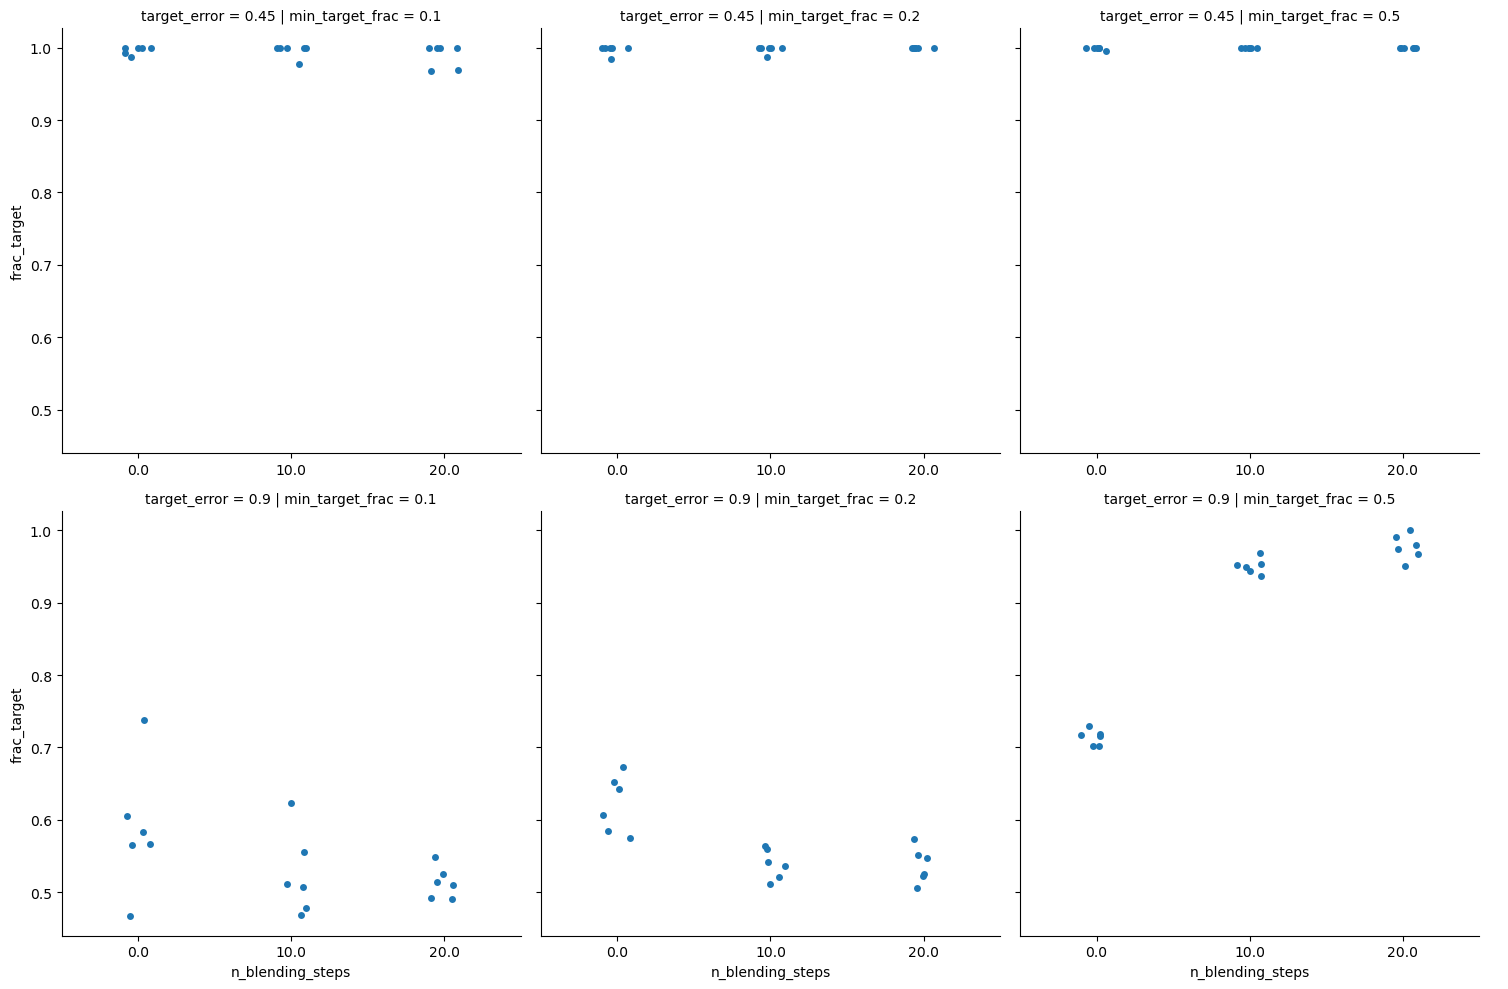

In [39]:
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            row='target_error',
            y='frac_target',
            data=frac_target,
            sharey=True,
            sharex=False)
plt.show()

## What's going on with the min target fraction? Can we look at whether we're being too cautious vs too optimistic? 

And does that relate to what we see in this plot? Perhaps measuring this class of mistake is a direction of future work? e.g. control on an FPR/FNR?

## Gradients

I look at the gradient in volume (per fs, so no demonimator).   
This should relate to the rapid oscillations. So hopefully blending makes it go away.

You can adjust the y variable in the catplot to see the effect in both the mean and max first and second order derivative


The takeaway from the max first derivative is that 
* for smaller target error -- it doesnt matter (unsurprising since in that cas we just use the DFT)
* for larger target error there are some huge gradients for no blending, but on about the right scale with blending

In [52]:
params

,file,starting_strc,temperature,timestep,calculator,ensemble,temp_tau,stress_tau,steps,seed,bulk_modulus,model_type,initial_model,initial_data,ensemble_size,online_training,training_epochs,training_batch_size,training_max_size,training_recency_bias,training_device,target_error,error_history,retrain_freq,min_target_frac,n_blending_steps,cascade_commit,my_commit,start_time,dir,hash
0,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,0,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,4.500000e-01,8,1024,0.5,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-20T10:47:59.971892,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,00e6f7df
1,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,0,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,4.500000e-01,8,1024,0.2,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-20T10:47:59.990908,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,05bd7fef
2,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,4,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,9.000000e-01,8,1024,0.1,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-21T16:40:41.998016,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,0aff6fba
3,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,2,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,9.000000e-01,8,1024,0.1,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-21T16:29:39.827520,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,105292bb
4,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,0,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,1.000000e-12,8,1024,1.0,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-20T16:04:19.628837,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,1418cfda
5,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,0,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,9.000000e-01,8,1024,0.2,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-20T10:47:59.995349,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,160f5dc6
6,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,3,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,4.500000e-01,8,1024,0.5,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-21T13:57:01.142338,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,1ffe8b75
7,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,4,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,4.500000e-01,8,1024,0.5,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-21T13:57:01.153744,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,24aacf2b
8,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,1,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,9.000000e-01,8,1024,0.5,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-20T10:47:59.981273,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,2fc33503
9,None,/home/mtynes/cascade/0_setup/initial-geometrie...,800.0,1,lda,npt,25,25.0,2048,4,98.0,ani,None,[],2,True,32,32,None,1.0,cpu,4.500000e-01,8,1024,0.1,0,884fa037daca2f12f3c528117ba8a386033dfd71,884fa037daca2f12f3c528117ba8a386033dfd71,2024-08-21T13:57:01.186546,runs/800K-npt-single-train/si-vacancy-2x2x2-te...,399f3417


In [40]:
v_diff = []
for _hash, g  in data.groupby('hash'): 
    diff = g['volume'].diff().abs()
    v_diff.append((_hash, diff.max(), diff.mean(), diff.std()))
v_diff = pd.DataFrame.from_records(v_diff, columns=['hash', 'diff_max', 'diff_mean', 'diff_sd'])

In [41]:
params = pd.merge(params, v_diff, on='hash')

In [42]:
v_diff = []
for _hash, g  in data.groupby('hash'): 
    diff = g['volume'].diff(2).abs()
    v_diff.append((_hash, diff.max(), diff.mean(), diff.std()))
v_diff = pd.DataFrame.from_records(v_diff, columns=['hash', 'diff2_max', 'diff2_mean', 'diff2_sd'])

In [43]:
params = pd.merge(params, v_diff, on='hash')

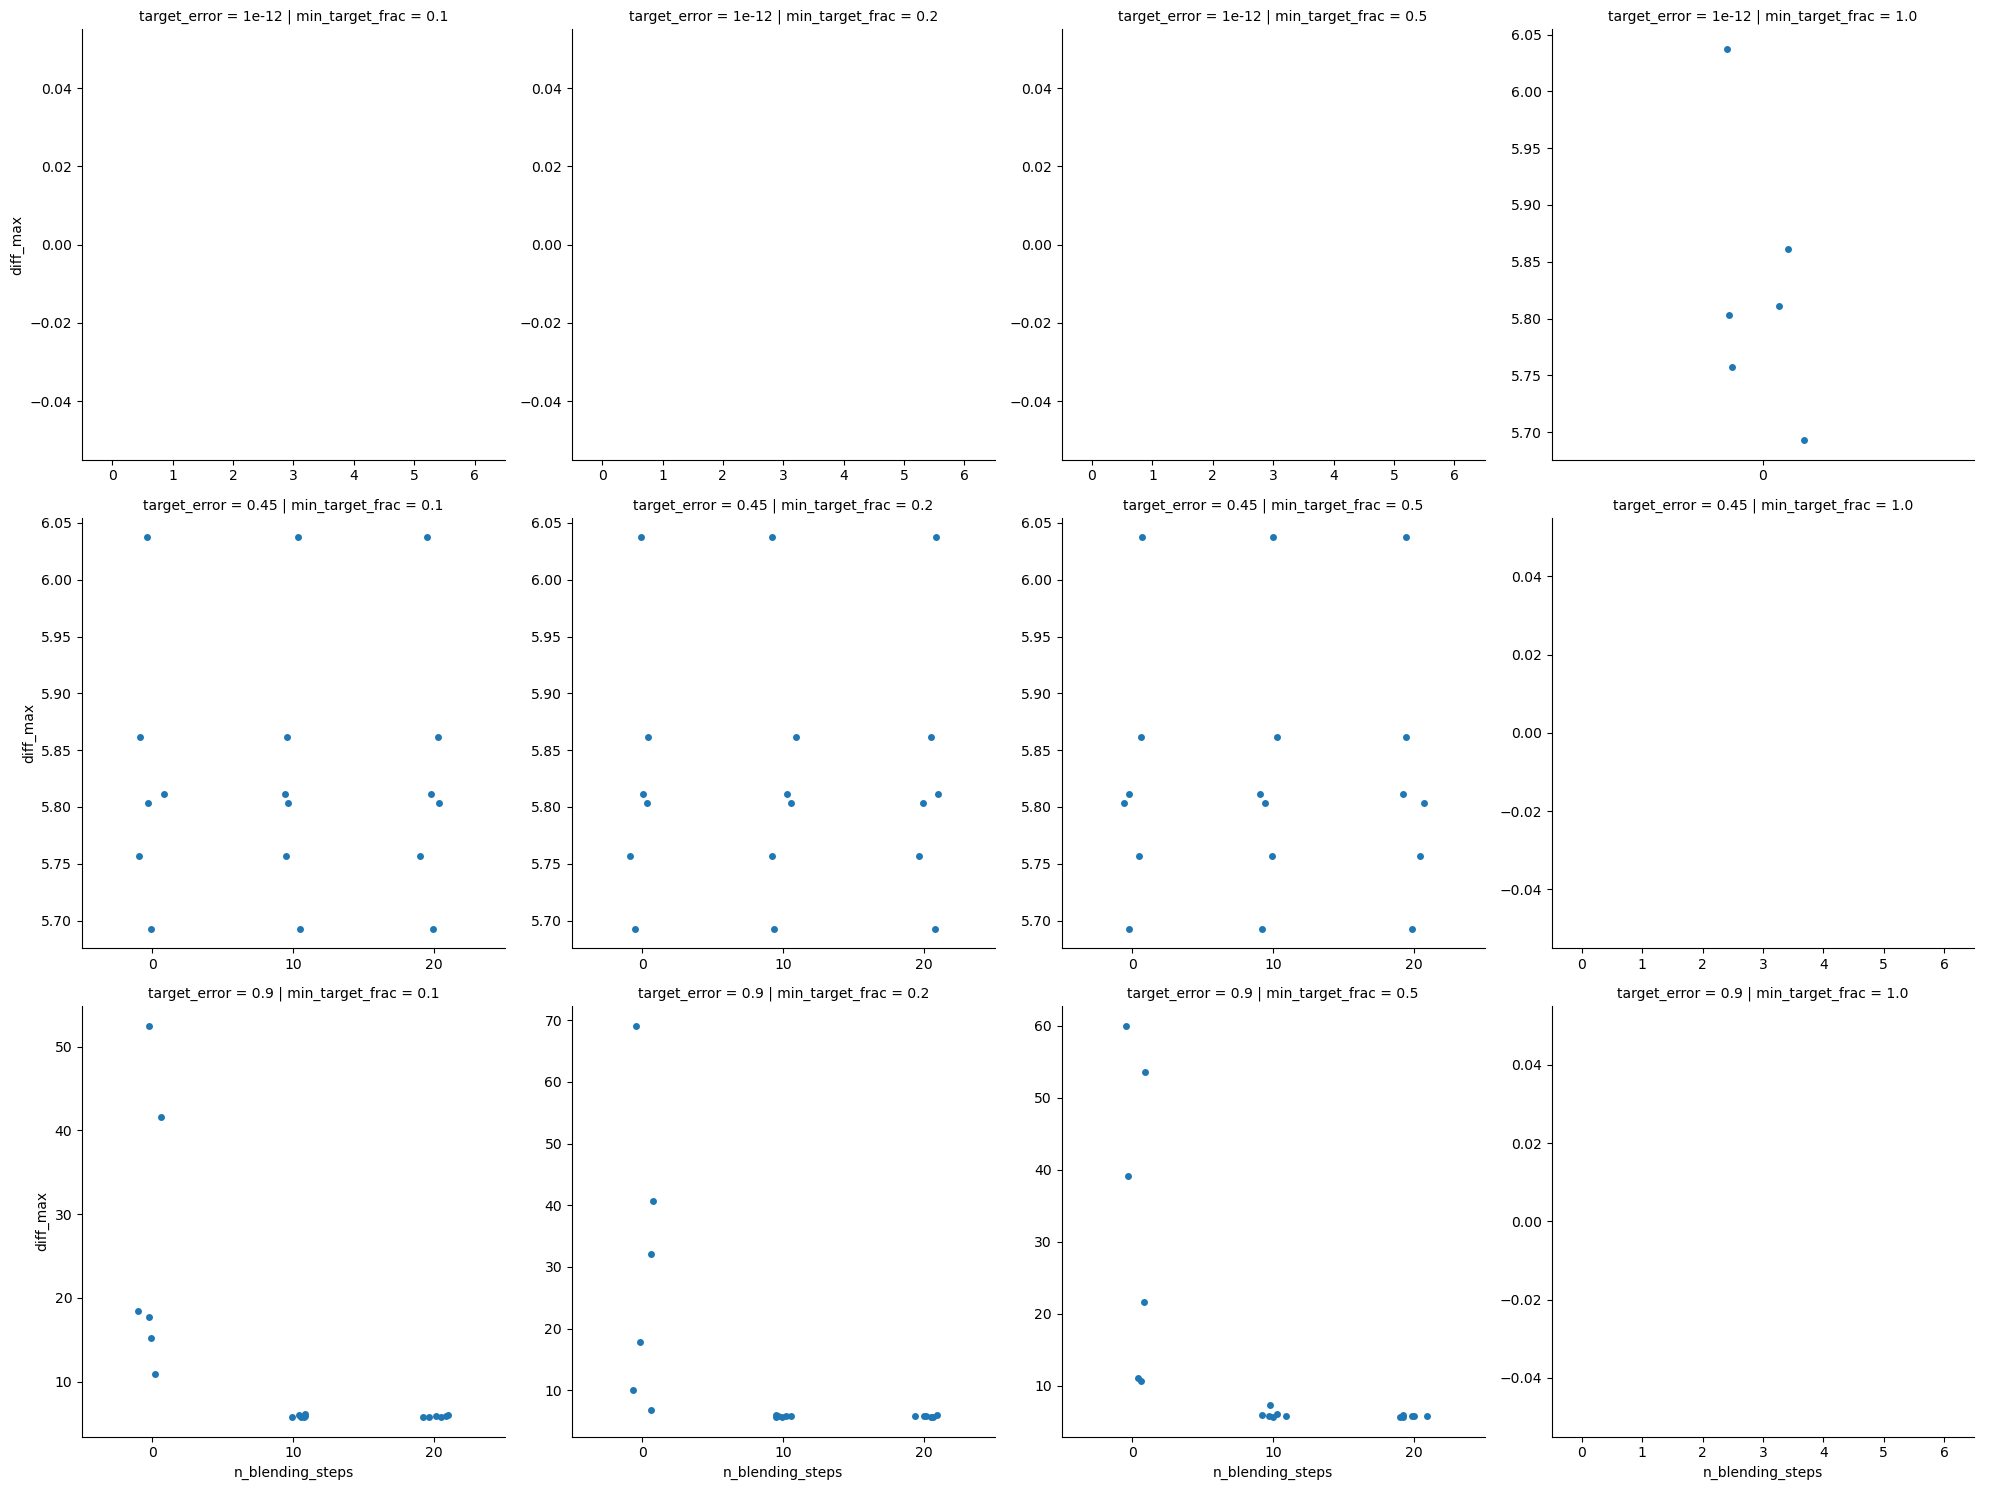

In [44]:
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            row='target_error',
            y='diff_max',
            #kind='box',
            #hue='seed',
            data=params,
            sharey=False,
            sharex=False)
plt.show()
#g.set(yscale='log')

### Zoomed in plot
We'll just look at the target_error=0.9 and min_target_frac=0.1 case
This is a good paper/slide figure

In [45]:
_data = params.query('target_error == 0.9 or target_error == 1e-12')
_data.loc[:, 'n_blend'] = pd.Categorical(_data['n_blending_steps'].astype('str'))
_data.loc[:, 'n_blend'] = _data['n_blend'].cat.add_categories(['DFT (reference)'])
_data.loc[_data['min_target_frac'] == 1, 'n_blend'] = 'DFT (reference)'
_data['n_blend'].cat.categories

/tmp/ipykernel_640377/657806853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.loc[:, 'n_blend'] = pd.Categorical(_data['n_blending_steps'].astype('str'))
/tmp/ipykernel_640377/657806853.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0', '0', '0', '0', '0', ..., '20', '20', '20', '20', '20']
Length: 60
Categories (4, object): ['0', '10', '20', 'DFT (reference)']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  _data.loc[:, 'n_blend'] = _data['n_blend'].cat.add_categories(['DFT (reference)'])


Index(['0', '10', '20', 'DFT (reference)'], dtype='object')

In [46]:
_data['n_blend'].unique()

['0', 'DFT (reference)', '10', '20']
Categories (4, object): ['0', '10', '20', 'DFT (reference)']

In [47]:
meth = []
for i, row in _data.iterrows():
    if row['n_blend'] == '0':
        meth.append('Proxima')
    elif row['n_blend'] == 'DFT (reference)': 
        meth.append('DFT (reference)')
    else: 
        meth.append('Proxima + blend')
_data['Method'] = pd.Categorical(meth, categories=['Proxima', 'Proxima + blend', 'DFT (reference)'])

/tmp/ipykernel_640377/3253428738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data['Method'] = pd.Categorical(meth, categories=['Proxima', 'Proxima + blend', 'DFT (reference)'])


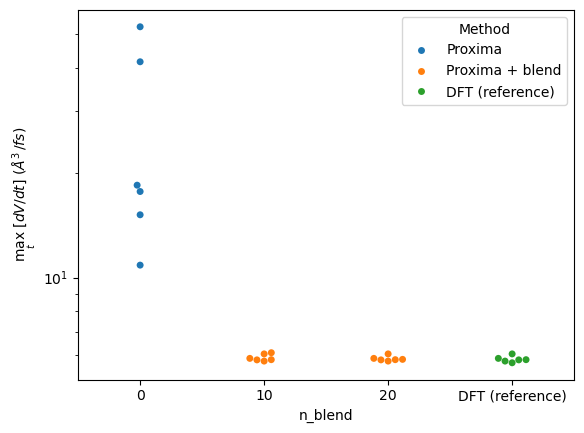

In [48]:
_data = _data.query('min_target_frac == 0.1 or min_target_frac == 1')
#_data = _data[_data['n_blend'] != "20"]
#_data['n_blend'] = _data['n_blend'].cat.remove_unused_categories()
ax = sns.swarmplot(x='n_blend', 
            y='diff_max',
            data=_data,
            hue='Method',
           )
plt.yscale('log')
plt.ylabel('$\max_t$ $[dV/dt]$ ($\AA^3/fs$)')
plt.show()
plt.savefig('volume_gradient_by_method.png', dpi=500)

Since the difference between 10 and 20 is quite small, lets just do blending vs no blending. 
And to make it more clear 

In [37]:
_data['hash'].nunique()

1

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 640x480 with 0 Axes>

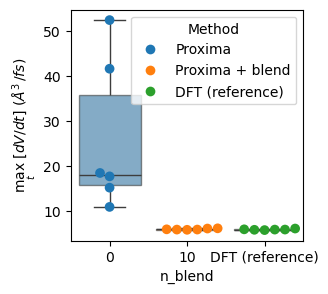

In [49]:
fig, ax = plt.subplots(figsize=(3,3))

_data = _data[_data['n_blend'] != "20"]
_data['n_blend'] = _data['n_blend'].cat.remove_unused_categories()
sns.boxplot(x='n_blend', 
            y='diff_max',
            data=_data,
            hue='Method',
            boxprops=dict(alpha=.6),
            showfliers=False,
            ax=ax
           )
ax.get_legend().remove()
sns.swarmplot(x='n_blend', 
            y='diff_max',
            data=_data,
            hue='Method',
            ax=ax,
            size=7
            )
leg, hand = ax.get_legend_handles_labels()
leg, hand = map(lambda l: l[3:], [leg, hand])
ax.legend(leg, hand, title='Method')
plt.ylabel('$\max_t$ $[dV/dt]$ ($\AA^3/fs$)')
plt.savefig('volume_gradient_by_method.png', dpi=500, bbox_inches='tight')
plt.show()

In [50]:
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [51]:
OLS = ols(formula = 'diff_max ~ C(n_blend)', data = _data).fit()
OLS.summary()

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_max   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     8.596
Date:                Wed, 11 Dec 2024   Prob (F-statistic):            0.00326
Time:                        14:21:09   Log-Likelihood:                -64.864
No. Observations:                  18   AIC:                             135.7
Df Residuals:                      15   BIC:                             138.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        26.0431      3.975      6.552      0.000      17.572      34.515
C(n_blend)[T.10]                -20.1506      5.621     -3.585      0.003     -32.131      -8.170
C(n_blend)[T.DFT (reference)]   -20.2159      5.621     -3.597      0.003     -32.197      -8.235
==============================================================================
Omnibus:                       12.269   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               10.069
Skew:                           1.307   Prob(JB):                      0.00651
Kurtosis:                       5.568   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
tukey_oneway = pairwise_tukeyhsd(endog = _data["diff_max"], groups = _data["n_blend"])

# Display the results
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,10,-20.1506,0.0072,-34.7507,-5.5505,True
0,DFT (reference),-20.2159,0.007,-34.816,-5.6158,True
10,DFT (reference),-0.0653,0.9999,-14.6654,14.5347,False


## Runtime and surrogate fraction

We look again at surrogate fraciton taking into account blending (i.e. we only count a step as "using the surrogate" if the blending was fully to the surrogate). 

First we look at naively saying we used the surrogate: 

In [53]:
frac_surrogate = []
for _hash, g  in data.groupby('hash'): 
    frac = g['used_surrogate'].mean()
    frac_surrogate.append((_hash, frac))
    
frac_surrogate = pd.DataFrame.from_records(frac_surrogate, columns=['hash', 'frac_surrogate'])

In [54]:
params = pd.merge(params, frac_surrogate, on='hash')

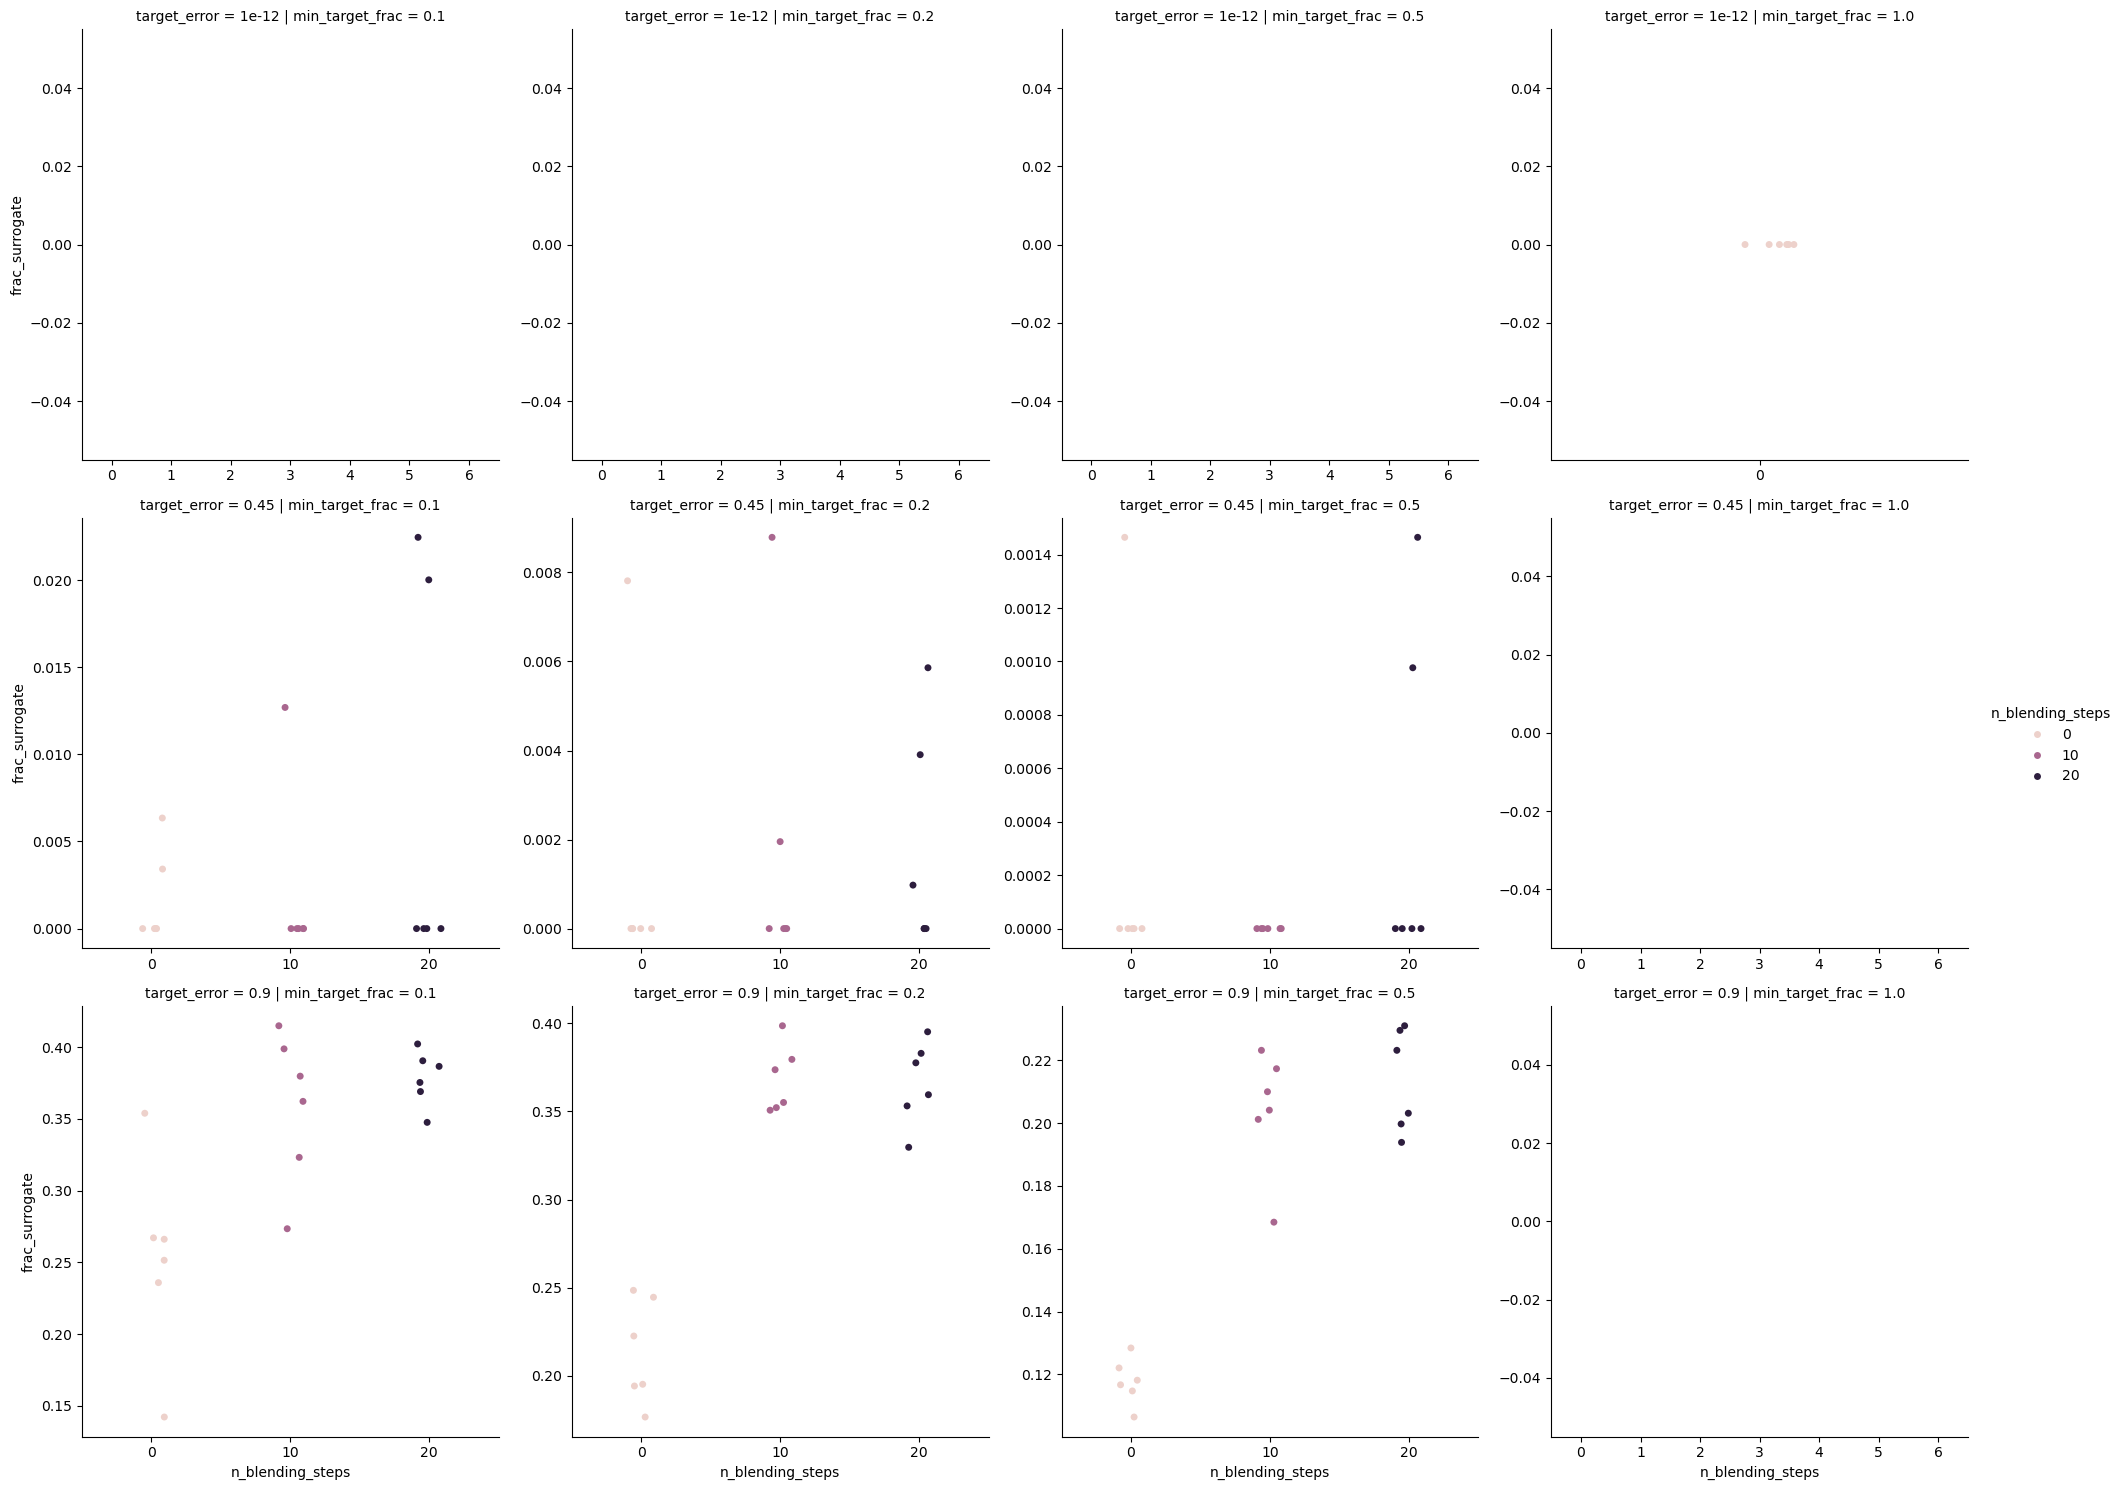

In [55]:
g = sns.catplot(x='n_blending_steps',
                hue='n_blending_steps',
            col='min_target_frac', 
            row='target_error',
            y='frac_surrogate',
            data=params,
            sharey=False,
            sharex=False)
plt.show()

Then we look at the full surrogate (and also save the runtime): 

In [56]:
data['full_surrogate'] = data['proxima_blending_step'] == data['n_blending_steps']

In [57]:
data = data.reset_index()

In [58]:
data.loc[data['n_blending_steps'] == 0, 'full_surrogate'] = data[data['n_blending_steps'] == 0]['used_surrogate']

In [59]:
data.loc[data['min_target_frac'] == 1, 'full_surrogate'] = False

In [60]:
stuff = []
for _hash, g  in data.groupby('hash'): 
    frac = g['full_surrogate'].mean()
    n_target_by_timestep = g['target_invocations'].max() / g['timestep'].max()
    runtime = g['step_time'].sum()
    stuff.append((_hash, frac, n_target_by_timestep, runtime))
stuff = pd.DataFrame.from_records(stuff, columns=['hash', 'full_surrogate', 'n_target_by_timestep', 'runtime'])

In [61]:
params = pd.merge(params, stuff, on='hash')

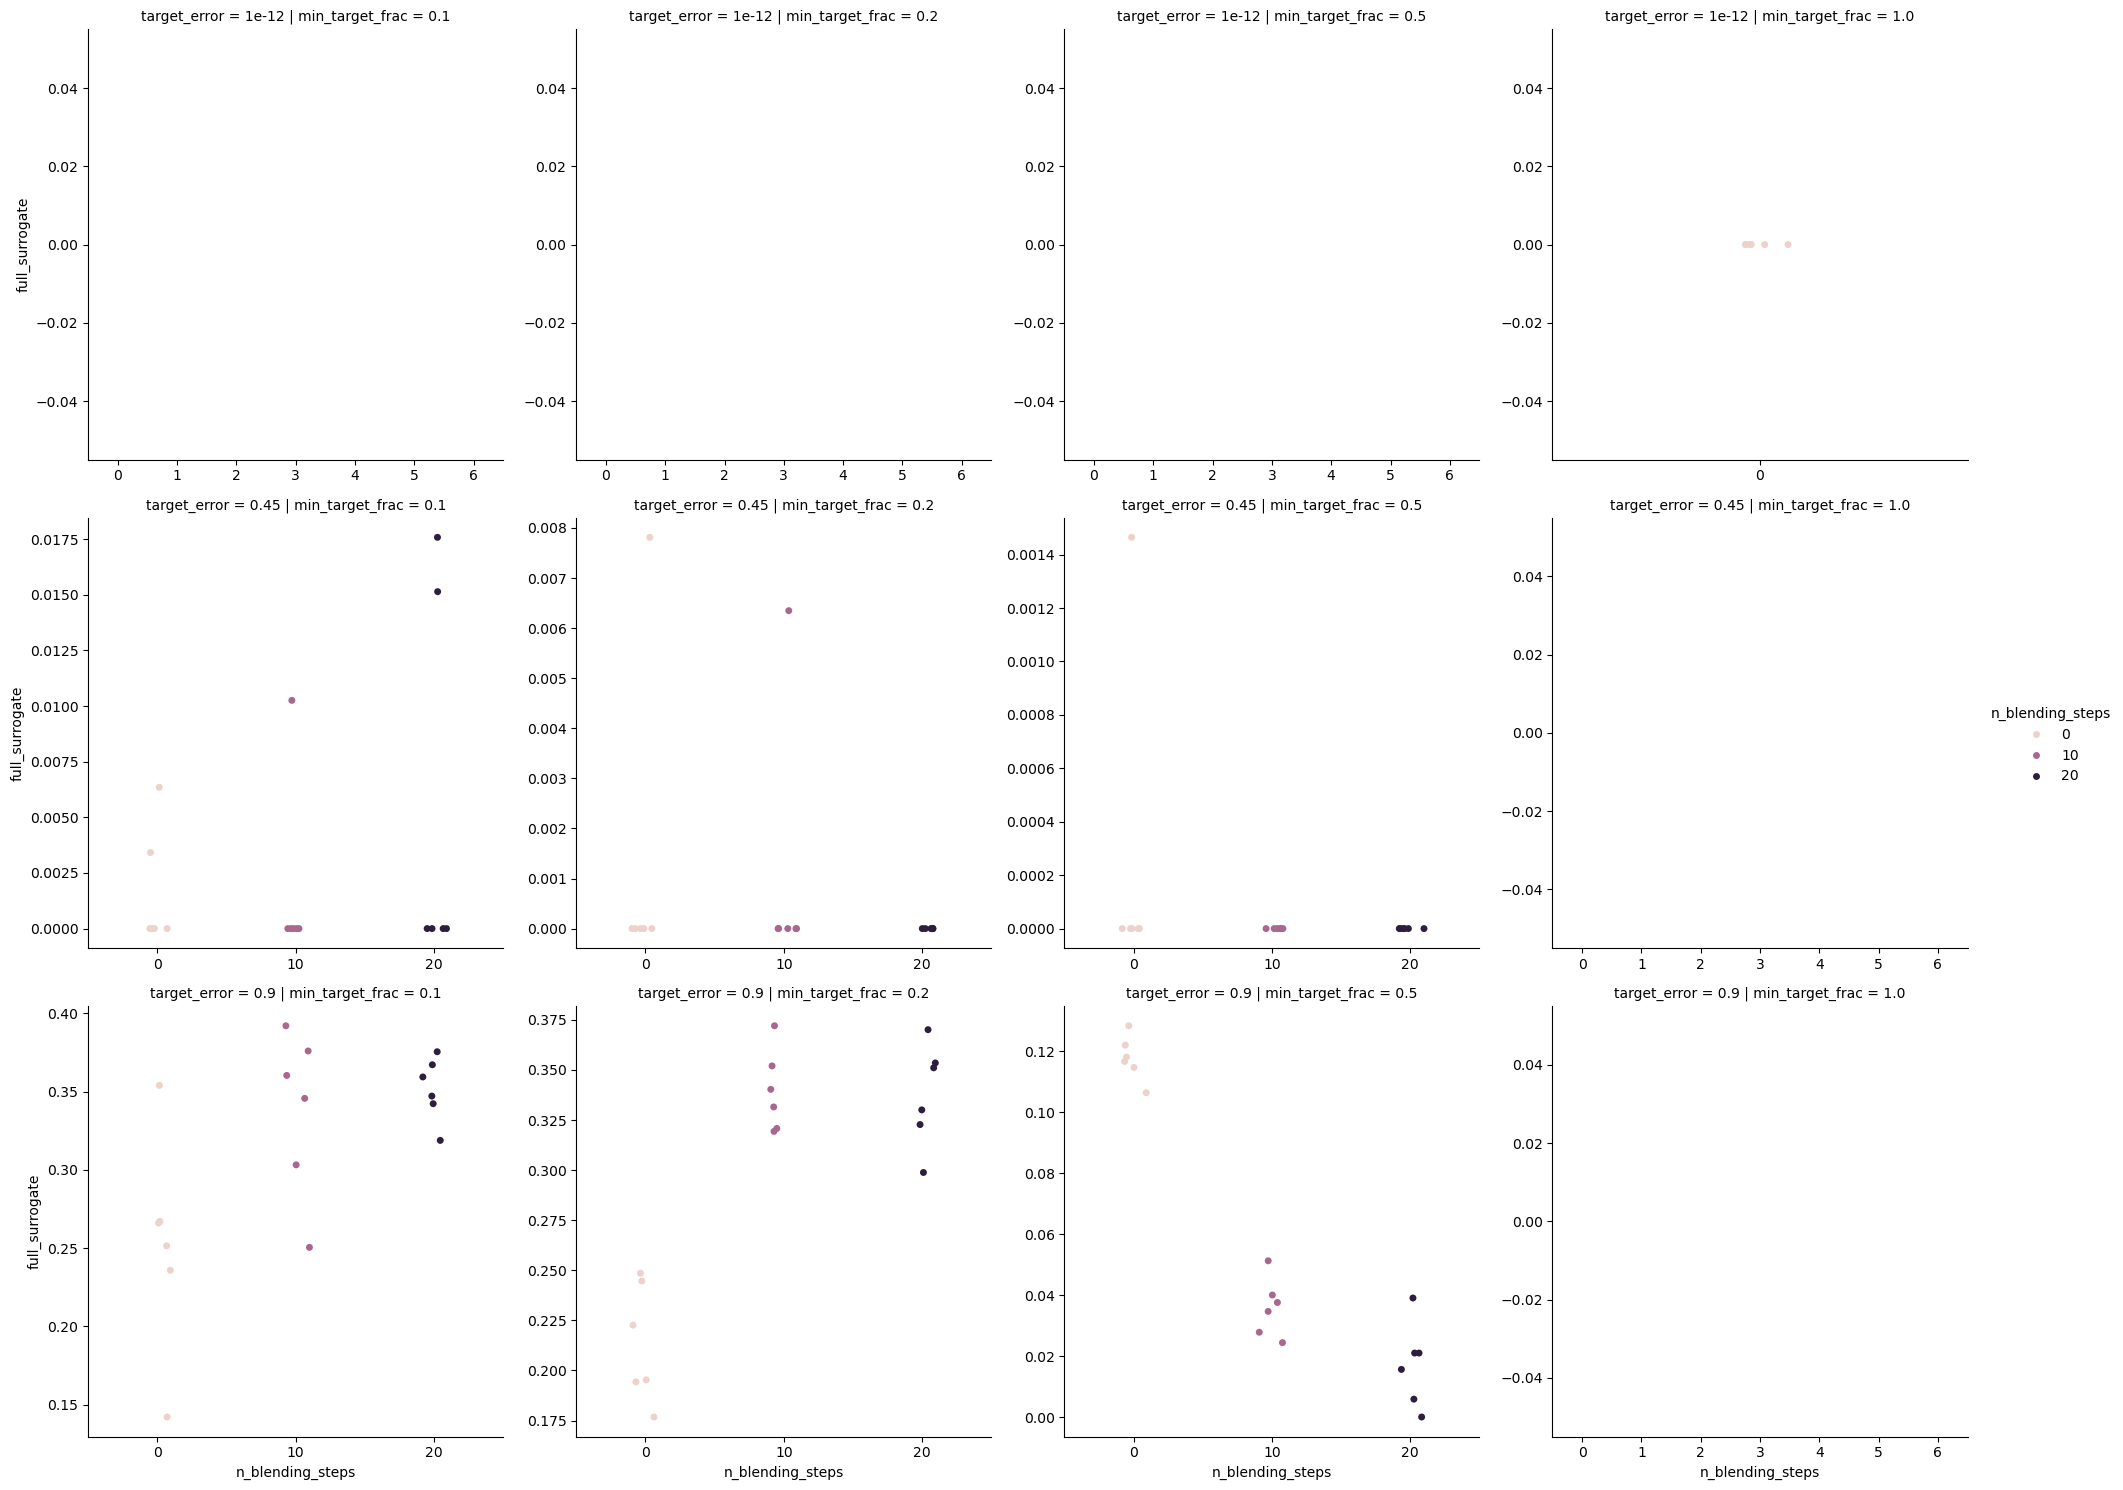

In [62]:
g = sns.catplot(x='n_blending_steps',
                hue='n_blending_steps',
            col='min_target_frac', 
            row='target_error',
            y='full_surrogate',
            data=params,
            sharey=False,
            sharex=False)
plt.show()

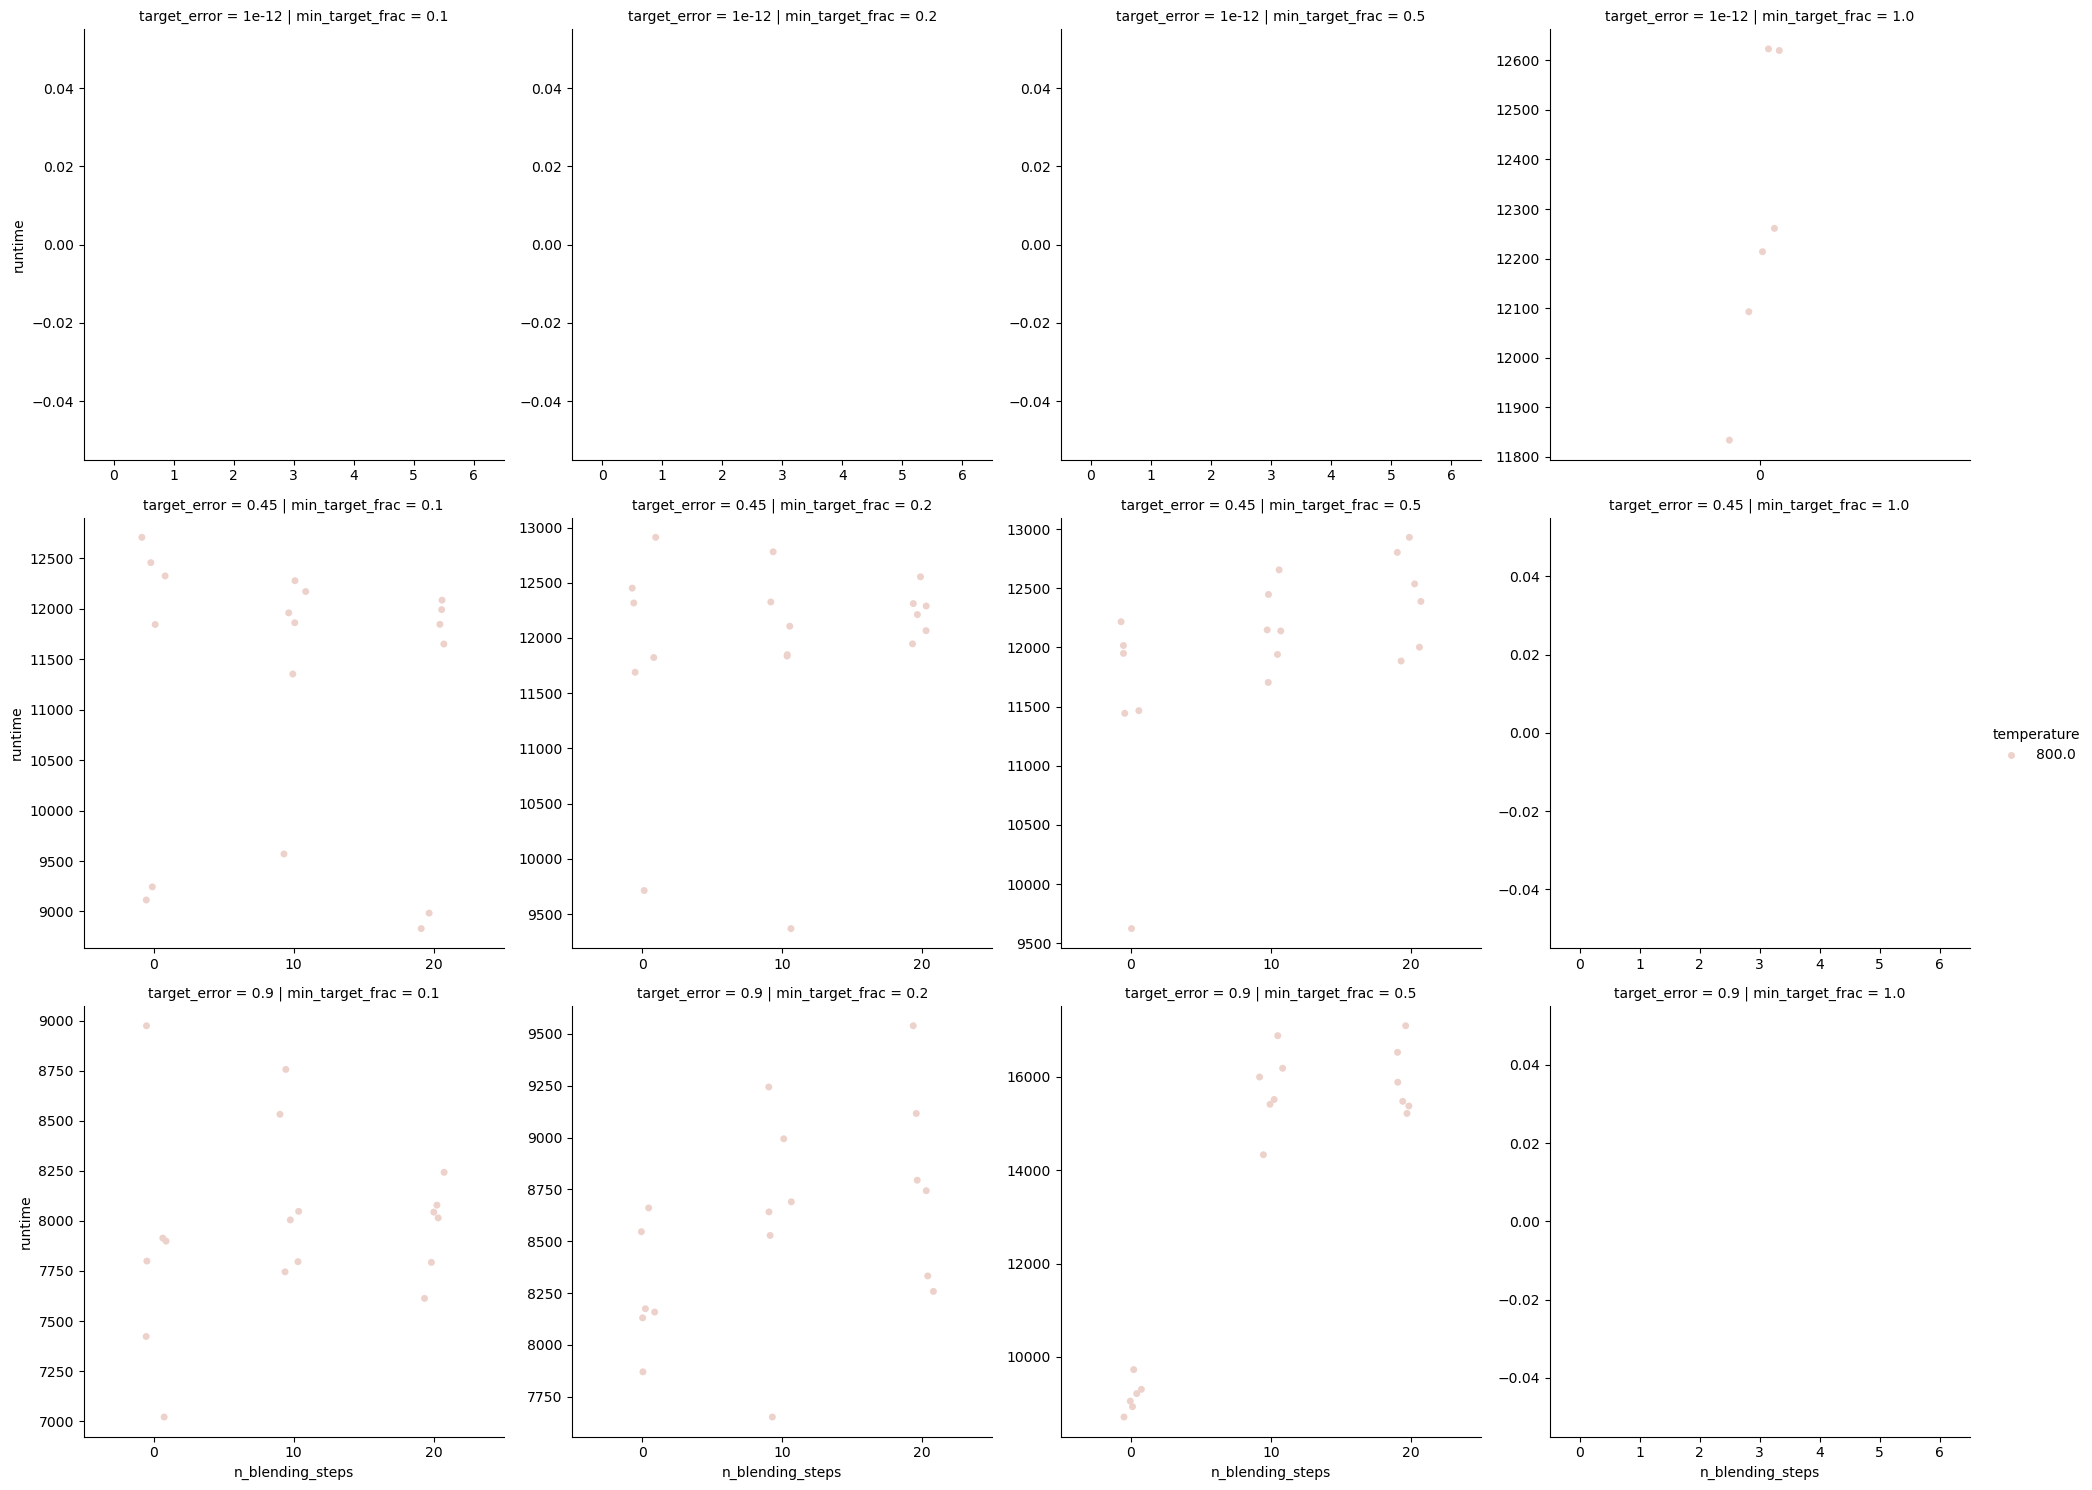

In [63]:
g = sns.catplot(x='n_blending_steps',
                hue='temperature',
            col='min_target_frac', 
            row='target_error',
            y='runtime',
            kind='strip',
            data=params,
            sharey=False,
            sharex=False)
plt.show()

### Zooming in on the runtime  
Looking at the same conditions as before that is target_error = 0.9 and target_frac = 0.1

In [64]:
_params = params.query('(target_error == 0.9 and min_target_frac == 0.1 and n_blending_steps <= 10) or min_target_frac == 1')

In [65]:
meth = []
for i, row in _params.iterrows():
    if row['min_target_frac'] == 1:
        meth.append('DFT (reference)')
    elif row['n_blending_steps'] == 0: 
        meth.append('Proxima')
    else: 
        meth.append('Proxima + blend')
_params['Method'] = pd.Categorical(meth, categories=['Proxima', 'Proxima + blend', 'DFT (reference)'])

/tmp/ipykernel_640377/3773392606.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _params['Method'] = pd.Categorical(meth, categories=['Proxima', 'Proxima + blend', 'DFT (reference)'])


In [66]:
_params['Method']

2             Proxima
3             Proxima
4     DFT (reference)
10    DFT (reference)
12            Proxima
14    DFT (reference)
15            Proxima
18    DFT (reference)
20            Proxima
21    DFT (reference)
34    DFT (reference)
35            Proxima
43    Proxima + blend
44    Proxima + blend
46    Proxima + blend
57    Proxima + blend
64    Proxima + blend
77    Proxima + blend
Name: Method, dtype: category
Categories (3, object): ['Proxima', 'Proxima + blend', 'DFT (reference)']

In [67]:
_params.loc[:, 'n_blend'] = pd.Categorical(_params['n_blending_steps'].astype('str'))
_params.loc[:, 'n_blend'] = _params['n_blend'].cat.add_categories(['DFT (reference)'])
_params.loc[_params['min_target_frac'] == 1, 'n_blend'] = 'DFT (reference)'

/tmp/ipykernel_640377/4172146100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _params.loc[:, 'n_blend'] = pd.Categorical(_params['n_blending_steps'].astype('str'))
/tmp/ipykernel_640377/4172146100.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0', '0', '0', '0', '0', ..., '10', '10', '10', '10', '10']
Length: 18
Categories (3, object): ['0', '10', 'DFT (reference)']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  _params.loc[:, 'n_blend'] = _params['n_blend'].cat.add_categories(['DFT (reference)'])


In [68]:
_params['runtime_h'] = _params['runtime'] / (60*60)

/tmp/ipykernel_640377/3242320047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _params['runtime_h'] = _params['runtime'] / (60*60)


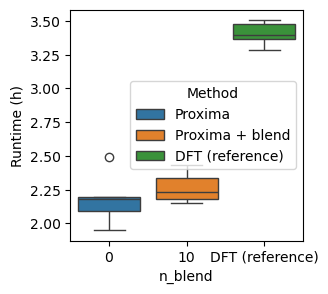

In [70]:
fig, ax = plt.subplots(figsize=(3,3))
sns.boxplot(y='runtime_h', 
            x='n_blend', 
            hue='Method', 
            data=_params, ax=ax)
plt.ylabel('Runtime (h)')
plt.savefig('speedup.png', 
            dpi=500,
            bbox_inches='tight')
plt.show()